### Time to get your hands dirty! Can a computer learn if we're going to detect gravitational waves?

This episode of "time to get your hands dirty" is about something I studied carefully in the past: gravitational-wave selection effects. This is one the LIGO interferometers:

![](https://www.ligo.caltech.edu/system/news_items/images/53/page/Virgo_aerial_view_01.jpg?1506530275)


All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). 
In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). In observational astronomy, this is known as [Malmquist bias](https://en.wikipedia.org/wiki/Malmquist_bias) and was first formulated in 1922.
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). If you've never seen them, the [.h5 format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) is a highly optimized storage strategy for large datasets. It's amazing. In python, you can read it with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in Sesana's gravitational-wave course; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course! Careful with overfitting here!).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features.

# Define the mesh grid
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict the class for each point in the mesh grid
Z = rf_clf.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)

# Plot the training points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor='k', marker='o', cmap=plt.cm.RdYlBu)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolor='k', marker='x', cmap=plt.cm.RdYlBu)

plt.xlabel('SNR')
plt.ylabel('Total Mass')
plt.xscale('log')
plt.yscale('log')
plt.title('Decision Boundary for RandomForestClassifier')
plt.show()

In [2]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
from matplotlib import colors

from sklearn.linear_model import LogisticRegression
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

In [3]:
data = h5py.File('../../sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')
list(data.keys())

['chi1x',
 'chi1y',
 'chi1z',
 'chi2x',
 'chi2y',
 'chi2z',
 'dec',
 'det',
 'iota',
 'mtot',
 'psi',
 'q',
 'ra',
 'snr',
 'z']

In [7]:
snr = data['snr'][:10000]
iota = data['iota'][:10000]
mtot= data['mtot'][:10000]
q = data['q'][:10000]
z = data['z'][:10000]
psi = data['psi'][:10000]
det =  data['det'][:10000]

print(len(snr))

10000


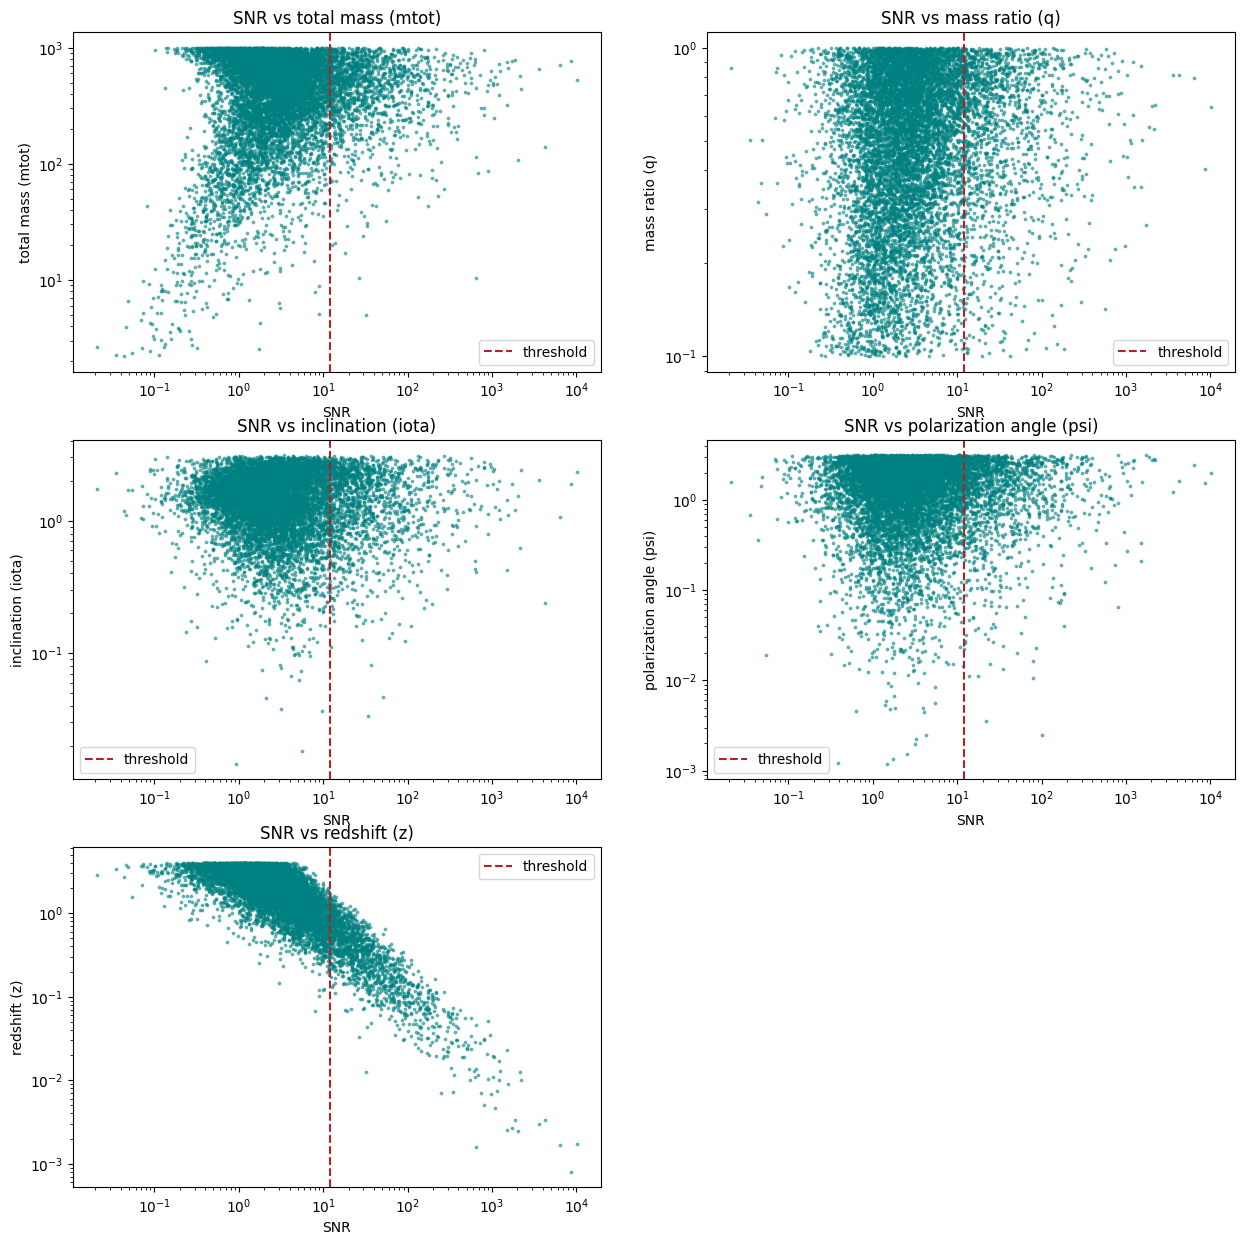

In [4]:
# List of variables to plot against snr
variables = [mtot, q, iota, psi, z]

# Titles for the plots
titles = ['total mass (mtot)', 'mass ratio (q)', 'inclination (iota)', 'polarization angle (psi)', 'redshift (z)']

# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()

# Plot each variable against snr
for i, (var, title) in enumerate(zip(variables, titles)):
    ax = axes[i]
    ax.scatter(snr, var, alpha=0.5, s = 3, c= "teal")
    ax.axvline(x=12, color='firebrick', linestyle='--', label = 'threshold')
    ax.set_xlabel('SNR')
    ax.set_ylabel(title)
    ax.set_title(f'SNR vs {title}')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()

# Remove the last empty subplot
fig.delaxes(axes[-1])



In [5]:
# should I use the SNR?????

X = np.array([mtot, q, iota, psi, z]).T
y = det

# Split the data into training and testing sets
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25], random_state=0)


## Logistic Regression

/home/malvi/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


completeness: 0.9394886363636363
contamination: 0.4182937554969217


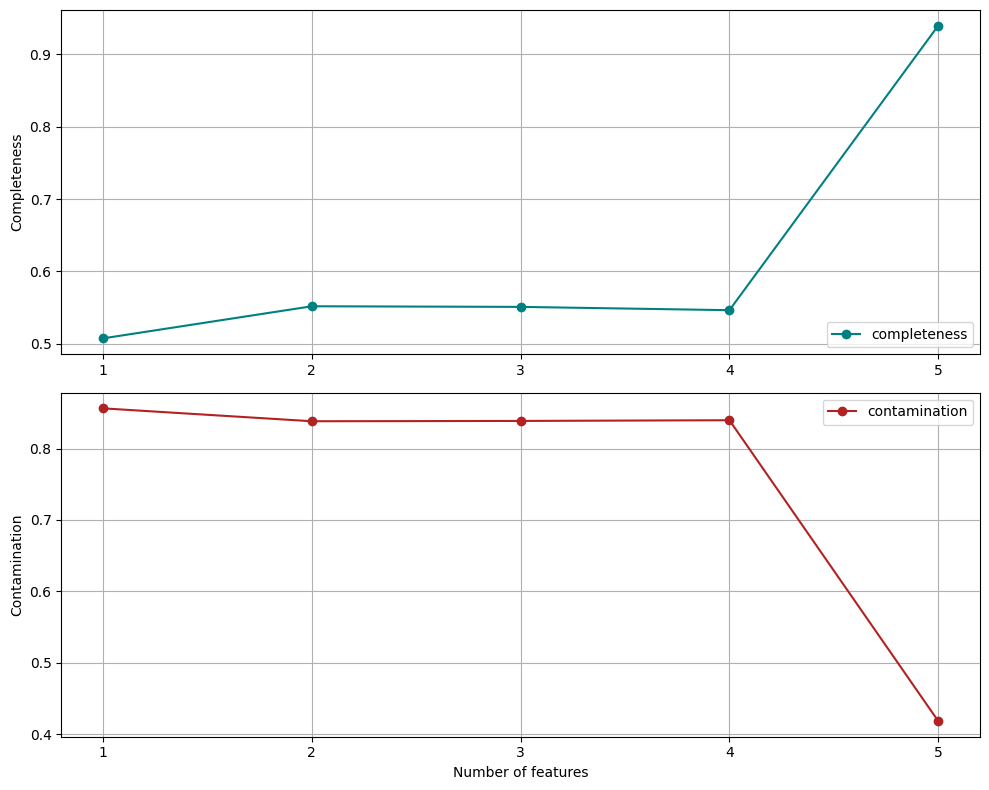

In [6]:
from sklearn.linear_model import LogisticRegression
from astroML.utils import completeness_contamination

n_features = np.arange(1, X.shape[1] + 1)

completeness = []
contamination = []

for nc in n_features:
    clf = LogisticRegression(class_weight='balanced')
    clf.fit(X_train[:, :nc], y_train)
    y_pred = clf.predict(X_test[:, :nc])

    comp, cont = completeness_contamination(y_pred, y_test)
    completeness.append(comp)
    contamination.append(cont)

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(n_features, completeness, 'o-',c = 'teal', ms=6, label = 'completeness')
ax[0].set_ylabel('Completeness')
ax[0].set_xticks(n_features)
ax[0].grid(True)
ax[0].legend(loc = 'lower right')

ax[1].plot(n_features, contamination, 'o-',c = 'firebrick', ms=6, label = 'contamination')
ax[1].set_xlabel('Number of features')
ax[1].set_ylabel('Contamination')
ax[1].set_xticks(n_features)
ax[1].grid(True)
ax[1].legend()

print('completeness:', completeness[-1])
print('contamination:', contamination[-1])

plt.tight_layout()
plt.show()




/home/malvi/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/malvi/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

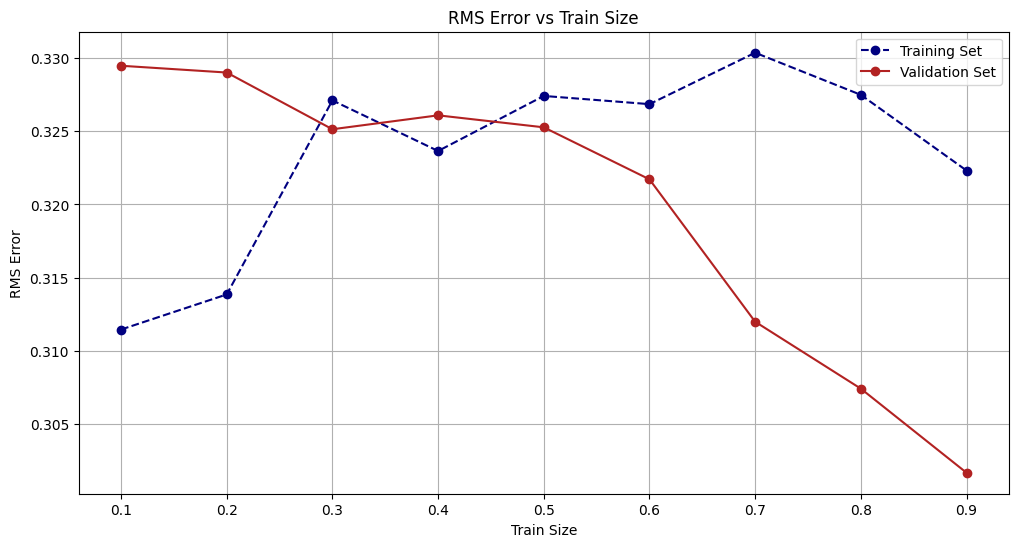

In [19]:
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

# Define the train sizes to evaluate
train_sizes = np.linspace(0.1, 0.9, 9)

# Arrays to store RMS errors
rms_errors_train = []
rms_errors_val = []

for train_size in train_sizes:
    # Split the data into training and testing sets with the current train size
    (X_train_var, X_val_var), (y_train_var, y_val_var) = split_samples(X, y, [train_size, 1 - train_size], random_state=0)
    
    # Initialize and fit the classifier
    clf = LogisticRegression(class_weight='balanced')
    clf.fit(X_train_var, y_train_var)
    
    # Predict on training set
    y_train_pred = clf.predict(X_train_var)
    rms_errors_train.append(np.sqrt(mean_squared_error(y_train_var, y_train_pred)))
    
    # Predict on validation set
    y_val_pred = clf.predict(X_val_var)
    rms_errors_val.append(np.sqrt(mean_squared_error(y_val_var, y_val_pred)))

# Plot RMS error vs train size
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, rms_errors_train,'o--', label='Training Set', color='navy')
plt.plot(train_sizes, rms_errors_val, 'o-k', label='Validation Set', color='firebrick')
plt.xlabel('Train Size')
plt.ylabel('RMS Error')
plt.title('RMS Error vs Train Size')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from astroML.utils import completeness_contamination

# Define the parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # 'liblinear' is a good choice for small datasets and supports both l1 and l2 penalties
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best estimator
best_log_reg = grid_search.best_estimator_
print(f"Best parameters for Logistic Regression: {grid_search.best_params_}")

# Evaluate the best Logistic Regression model on the test set
y_pred = best_log_reg.predict(X_test)
completeness, contamination = completeness_contamination(y_pred, y_test)
print(f"Completeness: {completeness}")
print(f"Contamination: {contamination}")

Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Completeness: 0.9305555555555556
Contamination: 0.3853211009174312


## Let's use different classifiers

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define the classifiers and their parameter grids
classifiers = {
    'RandomForest': RandomForestClassifier(random_state=0),
    'SVM': SVC(random_state=0),
    'DecisionTree': DecisionTreeClassifier(random_state=0)
}

param_grids = {
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'degree': [3, 4, 5]
    },
    'DecisionTree': {
        'max_depth': [None, 10, 20, 30],
        'max_features': ['auto', 'sqrt', 'log2']
    }
}



### Let's do cross validation to determine the parameters of the classifiers

In [30]:
import os

file_name = 'grid_search_results_es_20.npy'

if os.path.exists(file_name):
    best_classifiers = np.load(file_name, allow_pickle=True).item()
    print("Loaded existing grid search results.")
else:

    best_classifiers = {}
    for clf_name, clf in classifiers.items():
        grid_search = GridSearchCV(clf, param_grids[clf_name], cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        best_classifiers[clf_name] = grid_search.best_estimator_
        print(f"Best parameters for {clf_name}: {grid_search.best_params_}")

    np.save(file_name, best_classifiers)
    print("Saved grid search results to file.")



for clf_name, clf in best_classifiers.items():
    y_pred = clf.predict(X_test)
    print(f"Classification report for {clf_name}:\n{classification_report(y_test, y_pred)}")

/home/malvi/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/malvi/venv/lib/python3.1

Best parameters for RandomForest: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Best parameters for SVM: {'C': 10, 'degree': 3, 'kernel': 'linear'}
Best parameters for DecisionTree: {'max_depth': 10, 'max_features': 'sqrt'}
Saved grid search results to file.
Classification report for RandomForest:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2140
           1       0.90      0.82      0.86       360

    accuracy                           0.96      2500
   macro avg       0.94      0.90      0.92      2500
weighted avg       0.96      0.96      0.96      2500

Classification report for SVM:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      2140
           1       0.80      0.77      0.79       360

    accuracy                           0.94      2500
   macro avg       0.88      0.87      0.88      2500
weighted avg       0.94      0.94      0.94      2500


/home/malvi/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/malvi/venv/lib/python3.12

In [31]:
from astroML.utils import completeness_contamination

# Evaluate the best classifiers on the test set and calculate completeness and contamination
for clf_name, clf in best_classifiers.items():
    y_pred = clf.predict(X_test)
    completeness, contamination = completeness_contamination(y_pred, y_test)
    print(f"Classifier: {clf_name}")
    print(f"Completeness: {completeness}")
    print(f"Contamination: {contamination}")
    print("\n")

Classifier: RandomForest
Completeness: 0.8222222222222222
Contamination: 0.0975609756097561


Classifier: SVM
Completeness: 0.7666666666666667
Contamination: 0.19533527696793002


Classifier: DecisionTree
Completeness: 0.7944444444444444
Contamination: 0.1686046511627907




### Does it change anything using the data in log-scale?

In [32]:
X_log = np.log1p(X) 

(X_train_log, X_test_log), (y_train_log, y_test_log) = split_samples(X_log, y, [0.75, 0.25], random_state=0)

best_classifiers_log = {}
for clf_name, clf in classifiers.items():
    grid_search_log = GridSearchCV(clf, param_grids[clf_name], cv=5, scoring='accuracy')
    grid_search_log.fit(X_train_log, y_train_log)
    best_classifiers_log[clf_name] = grid_search_log.best_estimator_
    print(f"Best parameters for {clf_name} (log-transformed): {grid_search_log.best_params_}")

for clf_name, clf in best_classifiers_log.items():
    y_pred_log = clf.predict(X_test_log)
    completeness_log, contamination_log = completeness_contamination(y_pred_log, y_test_log)
    print(f"Classifier (log-transformed): {clf_name}")
    print(f"Completeness (log-transformed): {completeness_log}")
    print(f"Contamination (log-transformed): {contamination_log}")
    print("\n")

/home/malvi/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/malvi/venv/lib/python3.1

Best parameters for RandomForest (log-transformed): {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Best parameters for SVM (log-transformed): {'C': 100, 'degree': 3, 'kernel': 'rbf'}
Best parameters for DecisionTree (log-transformed): {'max_depth': 10, 'max_features': 'sqrt'}
Classifier (log-transformed): RandomForest
Completeness (log-transformed): 0.8222222222222222
Contamination (log-transformed): 0.0975609756097561


Classifier (log-transformed): SVM
Completeness (log-transformed): 0.8138888888888889
Contamination (log-transformed): 0.11746987951807229


Classifier (log-transformed): DecisionTree
Completeness (log-transformed): 0.7972222222222223
Contamination (log-transformed): 0.17052023121387283




/home/malvi/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/malvi/venv/lib/python3.12

Completeness: 0.85
Contamination: 0.12571428571428572


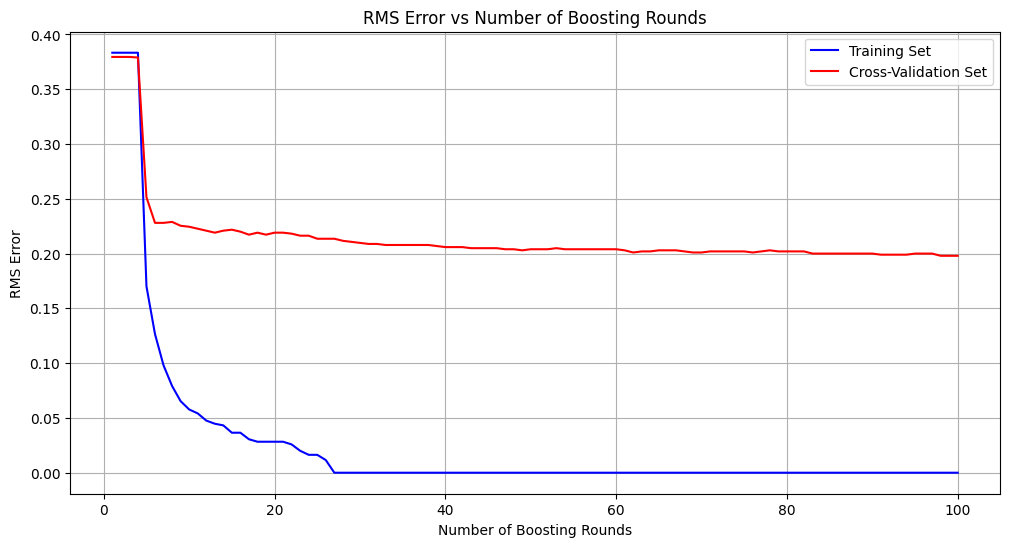

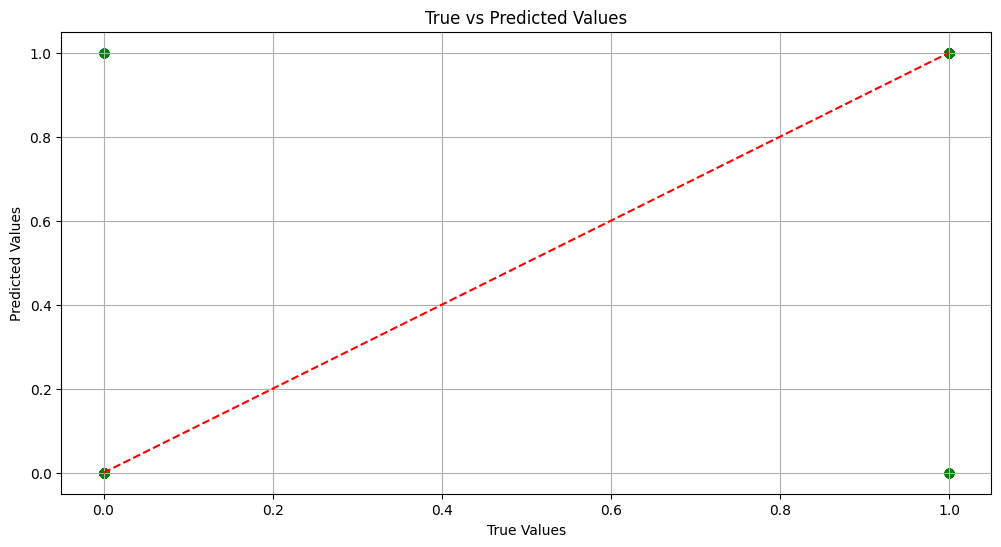

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error

# Initialize the GradientBoosting classifier
gb_clf = GradientBoostingClassifier(n_estimators=100, max_depth=10, random_state=0)

# Fit the GradientBoosting classifier on the training data
gb_clf.fit(X_train, y_train)

# Predict on the test data
y_pred_gb = gb_clf.predict(X_test)

# Calculate completeness and contamination
completeness_gb, contamination_gb = completeness_contamination(y_pred_gb, y_test)

print(f"Completeness: {completeness_gb}")
print(f"Contamination: {contamination_gb}")
# Number of boosting rounds
n_estimators = np.arange(1, 101)

# Arrays to store RMS errors
rms_errors_cv = []
rms_errors_train = []
for n in n_estimators:
    gb_clf = GradientBoostingClassifier(n_estimators=n, max_depth=10, random_state=0)
    gb_clf.fit(X_train, y_train)
    
    # Predict on training set
    y_train_pred = gb_clf.predict(X_train)
    rms_errors_train.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    
    # Predict on cross-validation set
    y_cv_pred = gb_clf.predict(X_test)
    rms_errors_cv.append(np.sqrt(mean_squared_error(y_test, y_cv_pred)))

# Plot RMS error vs number of boosting rounds
plt.figure(figsize=(12, 6))
plt.plot(n_estimators, rms_errors_train, label='Training Set', color='blue')
plt.plot(n_estimators, rms_errors_cv, label='Cross-Validation Set', color='red')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('RMS Error')
plt.title('RMS Error vs Number of Boosting Rounds')
plt.legend()
plt.grid(True)
plt.show()

# Plot true vs predicted values for the best model
best_n = n_estimators[np.argmin(rms_errors_cv)]
best_gb_clf = GradientBoostingClassifier(n_estimators=best_n, max_depth=10, random_state=0)
best_gb_clf.fit(X_train, y_train)
y_test_pred = best_gb_clf.predict(X_test)

plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, color='green')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.grid(True)
plt.show()


## Should we use a subset of the data?

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Try different subsets/combinations of the variables in X
subsets = [
    [0, 1],  # mtot, q
    [0, 2],  # mtot, iota
    [0, 3],  # mtot, psi
    [0, 4],  # mtot, z
    [1, 2],  # q, iota
    [1, 3],  # q, psi
    [1, 4],  # q, z
    [2, 3],  # iota, psi
    [2, 4],  # iota, z
    [3, 4]   # psi, z
]

results = {}

for subset in subsets:
    X_subset = X_scaled[:, subset]
    (X_train_subset, X_test_subset), (y_train_subset, y_test_subset) = split_samples(X_subset, y, [0.75, 0.25], random_state=0)
    
    best_classifiers_subset = {}
    for clf_name, clf in classifiers.items():
        grid_search = GridSearchCV(clf, param_grids[clf_name], cv=5, scoring='accuracy')
        grid_search.fit(X_train_subset, y_train_subset)
        best_classifiers_subset[clf_name] = grid_search.best_estimator_
    
    results[tuple(subset)] = best_classifiers_subset

# Evaluate the best classifiers on the test set for each subset
for subset, best_classifiers_subset in results.items():
    print(f"Subset: {subset}")
    for clf_name, clf in best_classifiers_subset.items():
        y_pred_subset = clf.predict(X_test_subset)
        completeness_subset, contamination_subset = completeness_contamination(y_pred_subset, y_test_subset)
        print(f"Classifier: {clf_name}")
        print(f"Completeness: {completeness_subset}")
        print(f"Contamination: {contamination_subset}")
        print("\n")

/home/malvi/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/malvi/venv/lib/python3.1

In [43]:
# save the results to a file
file_name = 'GVsearch_subsets_es20.npy'
np.save(file_name, results)
print("Saved grid search results to file.")


Saved grid search results to file.


In [45]:

# Load the results from the file
results = np.load('GVsearch_subsets_es20.npy', allow_pickle=True).item()

# Evaluate the best classifiers on the test set for each subset
for subset, best_classifiers_subset in results.items():
    print(f"Subset: {subset}")
    for clf_name, clf in best_classifiers_subset.items():
        y_pred_subset = clf.predict(X_test_subset)
        completeness_subset, contamination_subset = completeness_contamination(y_pred_subset, y_test_subset)
        print(f"Classifier: {clf_name}")
        print(f"Completeness: {completeness_subset}")
        print(f"Contamination: {contamination_subset}")
        print("\n")


Subset: (0, 1)
Classifier: RandomForest
Completeness: 0.025
Contamination: 0.9166666666666666


Classifier: SVM
Completeness: 0.0
Contamination: 0.0


Classifier: DecisionTree
Completeness: 0.2
Contamination: 0.7777777777777778


Subset: (0, 2)
Classifier: RandomForest
Completeness: 0.0
Contamination: 0.0


Classifier: SVM
Completeness: 0.0
Contamination: 0.0


Classifier: DecisionTree
Completeness: 0.05
Contamination: 0.8666666666666667


Subset: (0, 3)
Classifier: RandomForest
Completeness: 0.0
Contamination: 0.0


Classifier: SVM
Completeness: 0.0
Contamination: 0.0


Classifier: DecisionTree
Completeness: 0.125
Contamination: 0.5454545454545454


Subset: (0, 4)
Classifier: RandomForest
Completeness: 0.75
Contamination: 0.2857142857142857


Classifier: SVM
Completeness: 0.75
Contamination: 0.1891891891891892


Classifier: DecisionTree
Completeness: 0.725
Contamination: 0.2926829268292683


Subset: (1, 2)
Classifier: RandomForest
Completeness: 0.05
Contamination: 0.5


Classifier: SV

In [46]:
best_subset = None
best_completeness = 0
best_contamination = float('inf')

for subset, best_classifiers_subset in results.items():
    for clf_name, clf in best_classifiers_subset.items():
        y_pred_subset = clf.predict(X_test_subset)
        completeness_subset, contamination_subset = completeness_contamination(y_pred_subset, y_test_subset)
        
        if completeness_subset > best_completeness or (completeness_subset == best_completeness and contamination_subset < best_contamination):
            best_completeness = completeness_subset
            best_contamination = contamination_subset
            best_subset = subset

print(f"Best subset: {best_subset}")
print(f"Best completeness: {best_completeness}")
print(f"Best contamination: {best_contamination}")

Best subset: (3, 4)
Best completeness: 0.8
Best contamination: 0.2


I also tried PCA but it was terrible:

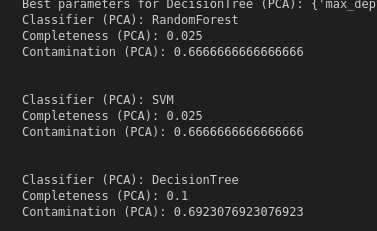

In [39]:
# Split the PCA-transformed data into training and testing sets
(X_train_pca, X_test_pca), (y_train_pca, y_test_pca) = split_samples(X_pca, y, [0.75, 0.25], random_state=0)

# Define the classifiers and their parameter grids for PCA-transformed data
param_grids_pca = {
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'degree': [3, 4, 5]
    },
    'DecisionTree': {
        'max_depth': [None, 10, 20, 30],
        'max_features': ['auto', 'sqrt', 'log2']
    }
}

# Perform GridSearchCV to find the best parameters for each classifier
best_classifiers_pca = {}
for clf_name, clf in classifiers.items():
    grid_search_pca = GridSearchCV(clf, param_grids_pca[clf_name], cv=5, scoring='accuracy')
    grid_search_pca.fit(X_train_pca, y_train_pca)
    best_classifiers_pca[clf_name] = grid_search_pca.best_estimator_
    print(f"Best parameters for {clf_name} (PCA): {grid_search_pca.best_params_}")

# Evaluate the best classifiers on the PCA-transformed test set and calculate completeness and contamination
for clf_name, clf in best_classifiers_pca.items():
    y_pred_pca = clf.predict(X_test_pca)
    completeness_pca, contamination_pca = completeness_contamination(y_pred_pca, y_test_pca)
    print(f"Classifier (PCA): {clf_name}")
    print(f"Completeness (PCA): {completeness_pca}")
    print(f"Contamination (PCA): {contamination_pca}")
    print("\n")

/home/malvi/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/malvi/venv/lib/python3.1

Best parameters for RandomForest (PCA): {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Best parameters for SVM (PCA): {'C': 100, 'degree': 3, 'kernel': 'rbf'}
Best parameters for DecisionTree (PCA): {'max_depth': 10, 'max_features': 'sqrt'}
Classifier (PCA): RandomForest
Completeness (PCA): 0.025
Contamination (PCA): 0.6666666666666666


Classifier (PCA): SVM
Completeness (PCA): 0.025
Contamination (PCA): 0.6666666666666666


Classifier (PCA): DecisionTree
Completeness (PCA): 0.1
Contamination (PCA): 0.6923076923076923




/home/malvi/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/malvi/venv/lib/python3.12

In [36]:
#----------------------------------------------------------------------
# get data and split into training & testing sets
Xnew = np.array([snr, mtot, iota]).T

print(np.shape(Xnew))
ynew = det
#Xnew = Xnew[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results
(X_train, X_test), (y_train, y_test) = split_samples(Xnew, ynew, [0.75, 0.25], random_state=0)

(1000, 3)


completeness [1. 1. 1.]
contamination [0.02439024 0.02439024 0.02439024]


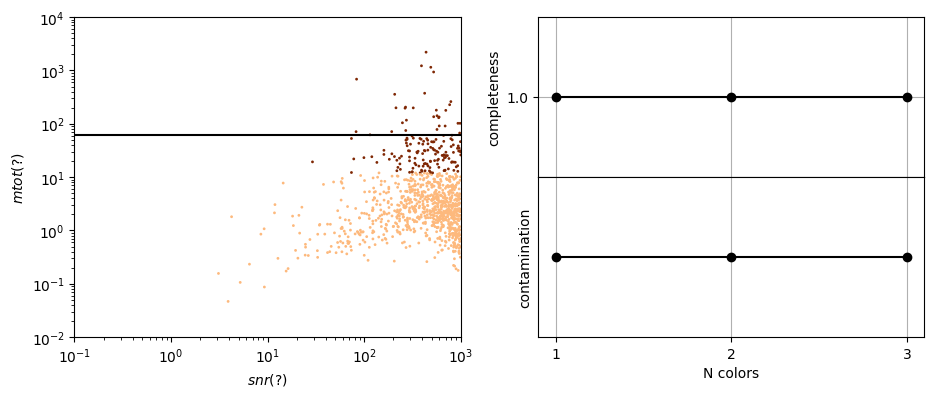

In [45]:

N_tot = len(ynew)
N_st = np.sum(ynew == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# perform Classification
classifiers = []
predictions = []
Ncolors = np.arange(1, Xnew.shape[1] + 1)

for nc in Ncolors:
    clf = LogisticRegression(class_weight='balanced')
    clf.fit(X_train[:, :nc], y_train)
    y_pred = clf.predict(X_test[:, :nc])

    classifiers.append(clf)
    predictions.append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1]
xlim = (0.1, 1000)
ylim = (0.01, 10**4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))

Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(Xnew[-N_plot:, 1], Xnew[-N_plot:, 0], c=ynew[-N_plot:],
                s=4, lw=0, cmap=plt.cm.Oranges, zorder=2)
im.set_clim(-0.5, 1)

ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.loglog()
ax.set_xlabel('$snr (?)$')
ax.set_ylabel('$mtot (?)$')

# plot completeness vs Ncolors
ax = fig.add_subplot(222)

ax.plot(Ncolors, completeness, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
#ax.set_xlim(0.5, 4.5)
#ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
#ax.set_xlim(0.5, 4.5)
#ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()